In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score
)

In [27]:
#uvoz skupa podataka

df = pd.read_csv('../freMTPL2freq.csv')
df = df.sample(n=100000, random_state=42)
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
261354,2122523.0,0,0.43,D,7,18,36,95,B1,Regular,1054,R24
448143,3173420.0,0,0.10,D,7,17,80,95,B2,Regular,598,R25
188618,1188619.0,0,0.33,E,7,3,36,76,B6,Regular,4172,R82
12952,31400.0,0,0.56,A,5,4,73,52,B13,Diesel,15,R24
425028,3138755.0,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53


In [28]:
df.shape

(100000, 12)

In [29]:
df.isna().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

In [30]:
df.duplicated().sum() #nemamo duplikata u skupu

0

In [31]:
# Nova kolona: da li je vozač imao bar jednu štetu
df['Risk'] = df['ClaimNb'].apply(lambda x: 1 if x > 0 else 0)


In [32]:
# Nova ciljana kolona: 1 ako postoji šteta (ClaimNb > 0), inače 0
df['Risk'] = (df['ClaimNb'] > 0).astype(int)

In [33]:
# Odabrane kolone (uključena 'DrivAge' za tvoju temu)
#X = df[['DrivAge', 'VehPower', 'BonusMalus', 'Area', 'Density']]
#X = pd.get_dummies(X, columns=['VehPower', 'BonusMalus', 'Area'])

features = ['DrivAge', 'VehAge', 'VehPower', 'Density', 'Exposure', 'BonusMalus', 'VehPower', 'BonusMalus', 'Area']

X = df[['DrivAge', 'VehPower', 'BonusMalus', 'Area', 'Density']]
X = pd.get_dummies(X, columns=['VehPower', 'BonusMalus', 'Area'])

y = df['Risk']

In [34]:
# Podela podataka na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

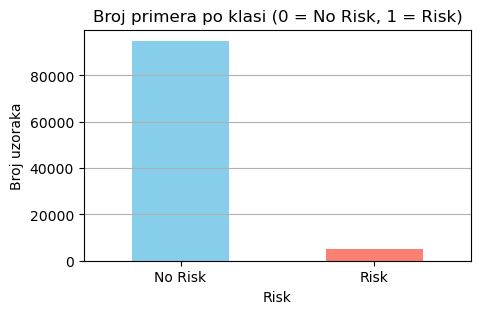

In [36]:
#balansiranost klasa

plt.figure(figsize=(5, 3))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Broj primera po klasi (0 = No Risk, 1 = Risk)')
plt.xticks([0, 1], ['No Risk', 'Risk'], rotation=0)
plt.ylabel('Broj uzoraka')
plt.grid(axis='y')
plt.show()

In [41]:
# Treniranje Naivnog Bajes modela
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [42]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [46]:
# Izveštaji
print("\nIzveštaj za test skup:")
print(classification_report(y_test, y_test_pred, target_names=['No Risk', 'Risk'], zero_division=0))
print(confusion_matrix(y_test, y_test_pred))

print("\nIzveštaj za trening skup:")
print(classification_report(y_train, y_train_pred, target_names=['No Risk', 'Risk'], zero_division=0))
print(confusion_matrix(y_train, y_train_pred))



Izveštaj za test skup:
              precision    recall  f1-score   support

     No Risk       0.95      0.48      0.64     28468
        Risk       0.06      0.56      0.10      1532

    accuracy                           0.49     30000
   macro avg       0.50      0.52      0.37     30000
weighted avg       0.91      0.49      0.61     30000

[[13775 14693]
 [  673   859]]

Izveštaj za trening skup:
              precision    recall  f1-score   support

     No Risk       0.91      0.49      0.64     66535
        Risk       0.65      0.95      0.77     66535

    accuracy                           0.72    133070
   macro avg       0.78      0.72      0.71    133070
weighted avg       0.78      0.72      0.71    133070

[[32596 33939]
 [ 3184 63351]]


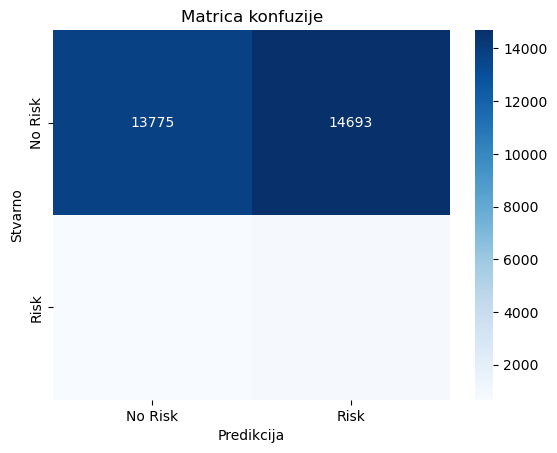

Matrica konfuzije (tekstualno) Test:
[[13775 14693]
 [  673   859]]


In [47]:
# matrica konfuzije
cnf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cnf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Risk', 'Risk'],
            yticklabels=['No Risk', 'Risk'])
plt.xlabel('Predikcija')
plt.ylabel('Stvarno')
plt.title('Matrica konfuzije')
plt.show()

# tekstualni ispis matrice
print("Matrica konfuzije (tekstualno) Test:")
print(cnf_matrix)

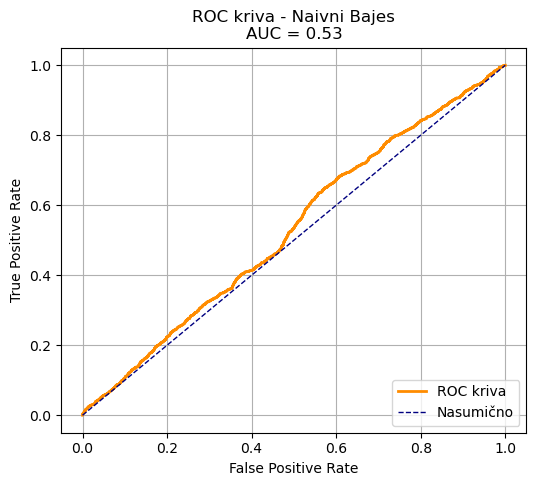

In [48]:
# roc kriva i auc
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC kriva')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Nasumično')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC kriva - Naivni Bajes\nAUC = {roc_auc:.2f}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

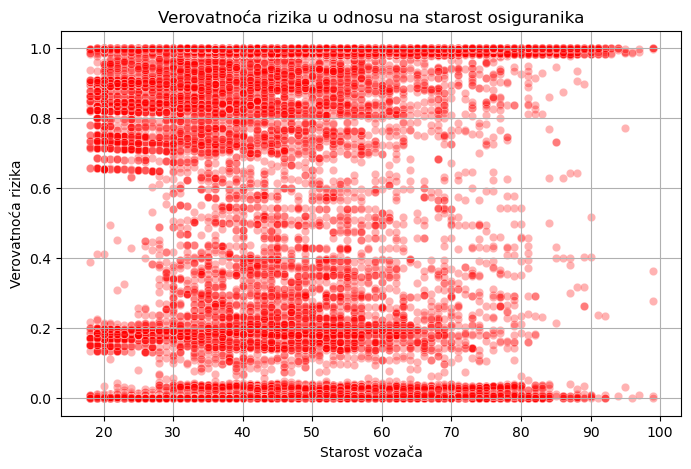

In [49]:
# verovatnoca rizika u odnosu na starost
risk_probs_all = model.predict_proba(X)[:, 1]
df_vis = df[['DrivAge']].copy()
df_vis['Risk_Prob'] = risk_probs_all

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_vis, x='DrivAge', y='Risk_Prob', alpha=0.3, color='red')
plt.title('Verovatnoća rizika u odnosu na starost osiguranika')
plt.xlabel('Starost vozača')
plt.ylabel('Verovatnoća rizika')
plt.grid(True)
plt.show()

c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


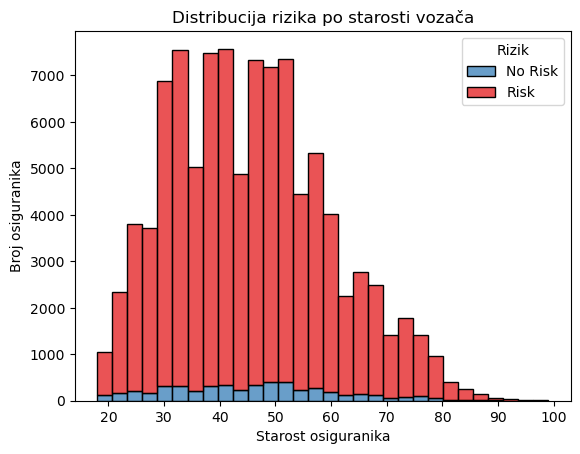

In [50]:
# rizik po starosnoj grupi
sns.histplot(data=df, x='DrivAge', hue='Risk', multiple='stack', bins=30, palette='Set1')
plt.title('Distribucija rizika po starosti vozača')
plt.xlabel('Starost osiguranika')
plt.ylabel('Broj osiguranika')
plt.legend(title='Rizik', labels=['No Risk', 'Risk'])
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22100\3628549829.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  example_data[col] = 0
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22100\3628549829.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  example_data[col] = 0
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22100\3628549829.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

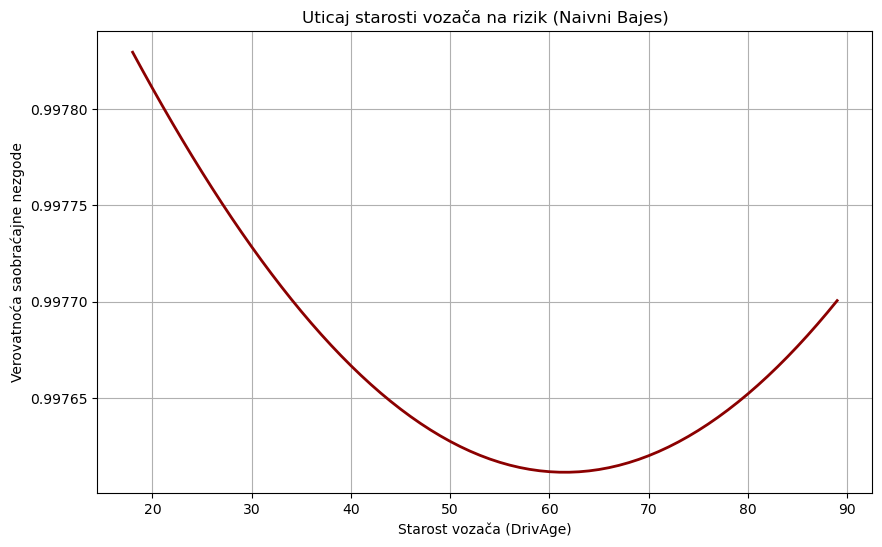

In [51]:
# Vizualizacija verovatnoće rizika u zavisnosti od starosti
# Generišemo uzraste od 18 do 89
ages = np.arange(18, 90)

# Pravimo DataFrame s istom strukturom kao X
# Koristimo najčešće vrednosti (mod) ili srednje vrednosti za ostale kolone
example_data = pd.DataFrame({
    'DrivAge': ages,
    'Density': df['Density'].median(),  # broj stanovnika po km2
})

# Dodaj dummy kolone (bonus, area, vehpower)
# Izvlačimo sve one dummy kolone koje model očekuje
dummy_columns = [col for col in X.columns if col not in ['DrivAge', 'Density']]

# Dodajemo sve dummy kolone s nulama
for col in dummy_columns:
    example_data[col] = 0

# Postavi neku tipičnu vrednost na jednu kategoriju (npr. BonusMalus_100)
for col in dummy_columns:
    if 'BonusMalus_100' in col:
        example_data[col] = 1
        break
    elif 'Area_' in col:
        example_data[col] = 1
        break

# Predikcija verovatnoće
risk_probs = model.predict_proba(example_data)[:, 1]

# Vizualizacija
plt.figure(figsize=(10, 6))
plt.plot(ages, risk_probs, color='darkred', linewidth=2)
plt.xlabel("Starost vozača (DrivAge)")
plt.ylabel("Verovatnoća saobraćajne nezgode")
plt.title("Uticaj starosti vozača na rizik (Naivni Bajes)")
plt.grid(True)
plt.show()